<a href="https://www.kaggle.com/code/kapturovalexander/classification-of-loan-borrowers?scriptVersionId=196879294" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

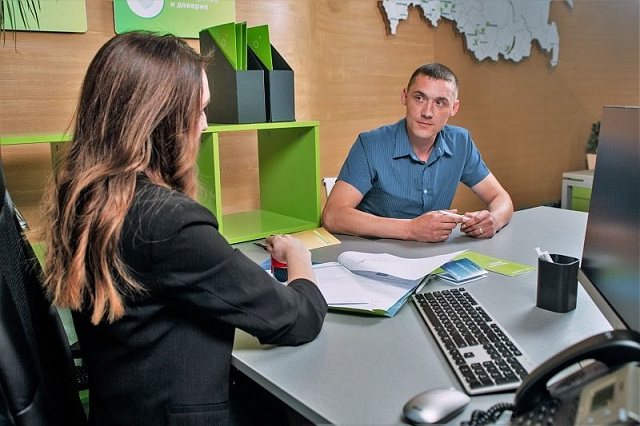

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-classification-for-banks/Training.xlsb
/kaggle/input/credit-classification-for-banks/Test.xlsb


## Table of Contents

- [Install library to open .xlsb file formats](#0)
- [Import libraries](#1)
- [Open data files](#2)
- [Show first 3 line of train data](#3)
- [Shape of train and test data](#4)
- [Check unique Train values for each property](#5)
- [Rename some properties' names](#6)
- [Look at new properites](#7)
- [Display descriptive statistics of train data](#8)
- [Let's look at the proportion of distinct values](#9)
- [Let's analyse target of train data](#10)
- [Let's analyse target of test data](#11)
- [Let's see how many NaN values are in data](#12)
- [Look at the data type of the training set](#13)
- [Split the training dataset into X and y](#14)
- [Split test data into answer (target of test)](#15)
- [Let's do a One-Hot transformation](#16)
- [Display a complete list of new features](#17)
- [Build a heat map of correlations (sns.heatmap produced anomalous errors)](#18)
- [Remove properties 'A', 'D' and 'E' to avoid multicorrelation](#19)
- [Check new correlation heatmap](#20)
- [Split training-data into train and test and use SMOKE to crash inbalance of classes](#21)
- [Define base models with tuned hyperparameters](#22)
- [Defining the meta-model with tuned hyperparameters](#23)
- [Creating the stacking model](#24)
- [Fitting the stacking model to the entire training data](#25)
- [Predict probabilities on the validation set](#26)
- [Predict probabilities on the test set](#27)
- [Calculate ROC AUC Score on the validation set](#28)
- [Calculate ROC AUC Score on the test set](#29)
- [Find out how many defaults are expected in test data](#30)
- [Build DataFrame to compare predictions with real results](#31)
- [Cheak how many data was predicted correctly](#32)

<a id='0'></a>
# <span style="color: green">🏦 Install library to open .xlsb file formats

In [2]:
!pip install pyxlsb

<a id='1'></a>
# <span style="color: green">🧑 Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
pd.set_option('display.max_columns', 100)  # Choose Your option
pd.set_option('display.max_rows', 100)

<a id='2'></a>
# <span style="color: green">👩‍🦰 Open data files

In [5]:
train = pd.read_excel(io='/kaggle/input/credit-classification-for-banks/Training.xlsb')
test = pd.read_excel(io='/kaggle/input/credit-classification-for-banks/Test.xlsb')

<a id='3'></a>
# <span style="color: green">Show first five lines of train data

In [6]:
train.head()

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


### <span style="color: green">Show first five lines of test data

In [7]:
test.head(3)

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.085400,0.085400,29.72,267.28,0.763657,0.763657,13,3.49,Woman,23.500000,Minsk region,13,NE employee,Secondary education (plus special education),Single/unmarried,1 One,property,No,No couple,Yes,Yes,No,No,No,0
1,2,0.223218,0.111609,0.00,1097.90,1.996182,0.998091,13,3.49,Woman,34.916667,Vitebsk region,48,NE employee,Secondary education (plus special education),Married,3 Three,property,No,Works,Yes,Yes,No,No,No,1
2,3,0.048400,0.048400,0.00,399.90,0.499875,0.499875,13,1.99,Man,41.750000,Vitebsk region,180,Head/Deputy head (division),Secondary education (plus special education),Married,0 Zero,property,No,Unemployed,Yes,Yes,No,No,No,0


<a id='4'></a>
# <span style="color: green">Shape of train and test data

In [8]:
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (89734, 26)
Test: (38405, 26)


<a id='5'></a>
# <span style="color: green">Check unique Train values for each property

In [9]:
for property in ['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'S']:
    print(property, train[property].unique(), sep='\n', end='\n\n')

I
['Woman' 'Man']

K
['Mogilev region' 'Minsk region' 'Vitebsk region' 'Brest region' 'Minsk'
 'Grodno region' 'Gomel region']

M
['NE employee' 'Pensioner' 'Head/Deputy head (organiz.)'
 'Head/Deputy head (division)' 'Enterpreneur']

N
['Secondary education (plus special education)'
 'Higher education (one or more)' 'Incomplete higher education'
 'Primary or lower secondary education']

O
['Married' 'Divorced/widow' 'Single/unmarried' 'Cohabitation']

P
['2 Two' '1 One' '0 Zero' '3 Three' 'More than 3']

Q
['property' 'otherwise' 'rent/hire']

S
['Works' 'No couple' 'Pensioner' 'Unemployed' 'Student']



#### <span style="color: orange">As we see, there are some properties that we can decrypt and rename it's initial properties' names</span>

<a id='6'></a>
# <span style="color: green">Rename some properties' names

In [10]:
train.rename(columns={'I': 'Sex'}, inplace=True)
train.rename(columns={'K': 'Region'}, inplace=True)
train.rename(columns={'M': 'Job_title'}, inplace=True)
train.rename(columns={'N': 'Education'}, inplace=True)
train.rename(columns={'O': 'Marriage'}, inplace=True)
train.rename(columns={'P': 'Children'}, inplace=True)
train.rename(columns={'Q': 'Property'}, inplace=True)
train.rename(columns={'S': 'Employment_status'}, inplace=True)

test.rename(columns={'I': 'Sex'}, inplace=True)
test.rename(columns={'K': 'Region'}, inplace=True)
test.rename(columns={'M': 'Job_title'}, inplace=True)
test.rename(columns={'N': 'Education'}, inplace=True)
test.rename(columns={'O': 'Marriage'}, inplace=True)
test.rename(columns={'P': 'Children'}, inplace=True)
test.rename(columns={'Q': 'Property'}, inplace=True)
test.rename(columns={'S': 'Employment_status'}, inplace=True)

<a id='7'></a>
# <span style="color: green">Look at new properites

In [11]:
train.head(3)

,ID,A,B,C,D,E,F,G,H,Sex,J,Region,L,Job_title,Education,Marriage,Children,Property,R,Employment_status,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0


<a id='8'></a>
# <span style="color: green">Display descriptive statistics of train data

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,89734.0,44867.500000,25904.118865,1.000000,22434.250000,44867.500000,67300.750000,89734.000000
A,89734.0,0.167863,0.153851,0.000002,0.065843,0.119133,0.220000,7.067250
B,89734.0,0.113511,0.105340,0.000001,0.042922,0.079733,0.146990,0.874025
C,89734.0,85.801266,105.366771,0.000000,20.570000,50.020000,108.930000,2682.420000
D,89734.0,548.507954,448.686233,49.980000,227.030000,408.735000,746.710000,4999.000000
E,89734.0,1.011455,0.910583,0.000016,0.405983,0.749403,1.333367,35.337000
F,89734.0,0.683640,0.622047,0.000012,0.263775,0.499387,0.899260,10.352991
G,89734.0,7.854358,4.754588,2.000000,4.000000,5.000000,13.000000,24.000000
H,89734.0,0.510274,0.928146,0.000000,0.000000,0.000000,0.010000,3.500000
J,89734.0,41.140778,11.129976,21.000000,32.083333,40.000000,50.000000,64.916667


In [13]:
train.describe(include=['object', 'bool'])

,Sex,Region,Job_title,Education,Marriage,Children,Property,R,Employment_status,T,U,V,W,X
count,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734
unique,2,7,5,4,4,5,3,2,5,2,2,3,2,2
top,Woman,Minsk region,NE employee,Secondary education (plus special education),Married,0 Zero,property,No,Works,Yes,Yes,No,No,No
freq,48996,15274,72475,58363,63273,44229,81457,74357,47413,75356,76546,78462,51577,55095


### <span style="color: green">Display histograms of distribution

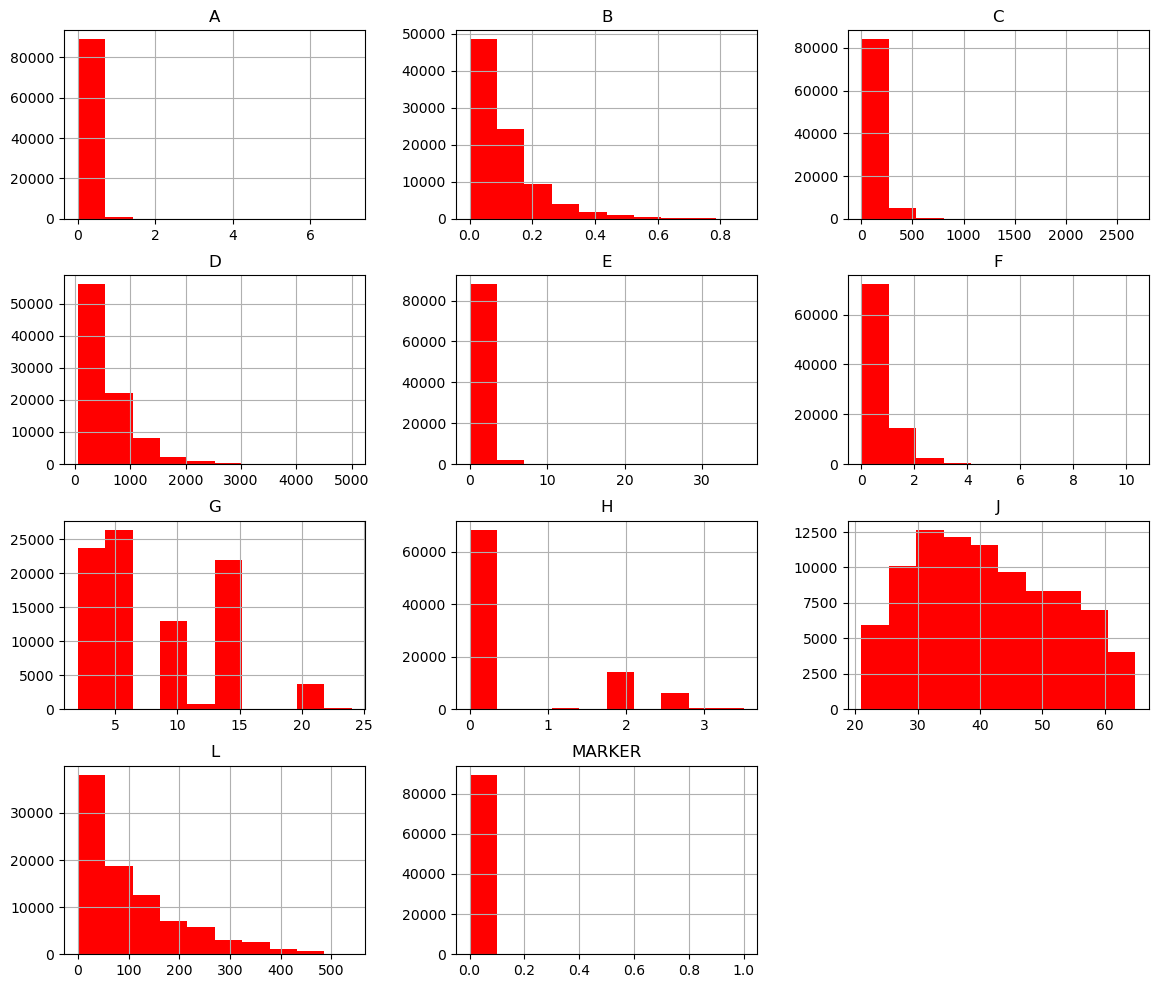

In [14]:
train.drop('ID', axis=1).hist(figsize=(14, 12), color='red');

<a id='9'></a>
# <span style="color: green">Let's look at the proportion of distinct values

### <span style="color: green">Pivot tables (2 variants)

In [15]:
pd.crosstab(index=train['MARKER'], columns=train['Marriage'])

Marriage,Cohabitation,Divorced/widow,Married,Single/unmarried
MARKER,,,,
0,2117,11331,63110,12834
1,9,77,163,93


In [16]:
pd.crosstab(index=train['MARKER'], columns=train['Marriage'], normalize=True)

Marriage,Cohabitation,Divorced/widow,Married,Single/unmarried
MARKER,,,,
0,0.023592,0.126273,0.703301,0.143023
1,0.000100,0.000858,0.001816,0.001036


In [17]:
pd.pivot_table(data=train, values='MARKER', index='Marriage', columns='Education', aggfunc='count')

Education,Higher education (one or more),Incomplete higher education,Primary or lower secondary education,Secondary education (plus special education)
Marriage,,,,
Cohabitation,508,16,14,1588
Divorced/widow,3354,69,60,7925
Married,21562,511,212,40988
Single/unmarried,4680,337,48,7862


In [18]:
for property in ['Sex', 'Region', 'Job_title', 'Education', 'Marriage', 'Property', 'Employment_status']:
    print(train[property].value_counts(), train[property].value_counts() / train.shape[0], sep='\n\n', end='\n\n')
    print('-' * 50)

Woman    48996
Man      40738
Name: Sex, dtype: int64

Woman    0.546014
Man      0.453986
Name: Sex, dtype: float64

--------------------------------------------------
Minsk region      15274
Minsk             14012
Brest region      13897
Grodno region     12614
Vitebsk region    12560
Gomel region      12493
Mogilev region     8884
Name: Region, dtype: int64

Minsk region      0.170214
Minsk             0.156150
Brest region      0.154869
Grodno region     0.140571
Vitebsk region    0.139969
Gomel region      0.139223
Mogilev region    0.099004
Name: Region, dtype: float64

--------------------------------------------------
NE employee                    72475
Head/Deputy head (division)     6304
Pensioner                       5951
Enterpreneur                    2725
Head/Deputy head (organiz.)     2279
Name: Job_title, dtype: int64

NE employee                    0.807665
Head/Deputy head (division)    0.070252
Pensioner                      0.066318
Enterpreneur                 

### <span style="color: green">Display value counts for 'Sex'

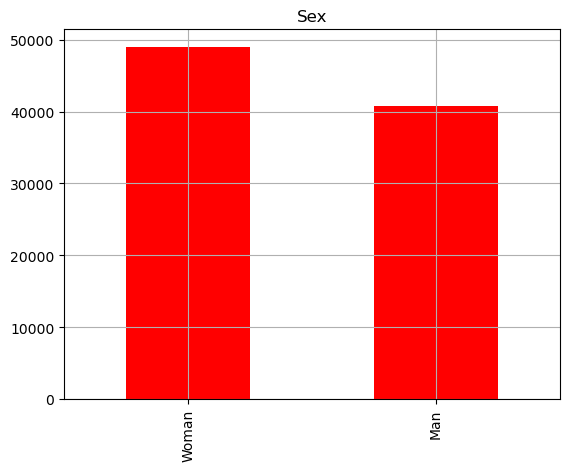

In [19]:
train['Sex'].value_counts().plot(kind='bar', color='red')
plt.grid()
plt.title('Sex');

#### Men and wemen are almost equal in quantity (women about 55%)

### <span style="color: green">Display value counts for 'Job_title'

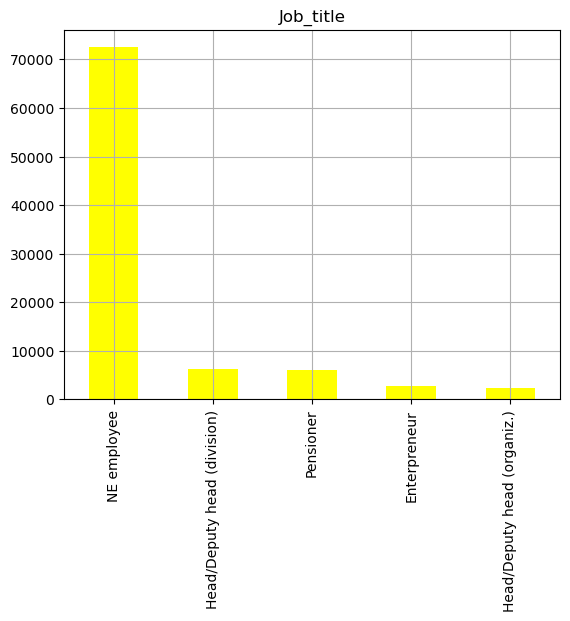

In [20]:
train['Job_title'].value_counts().plot(kind='bar', color='yellow')
plt.grid()
plt.title('Job_title');

### <span style="color: green">Display value counts for 'Education'

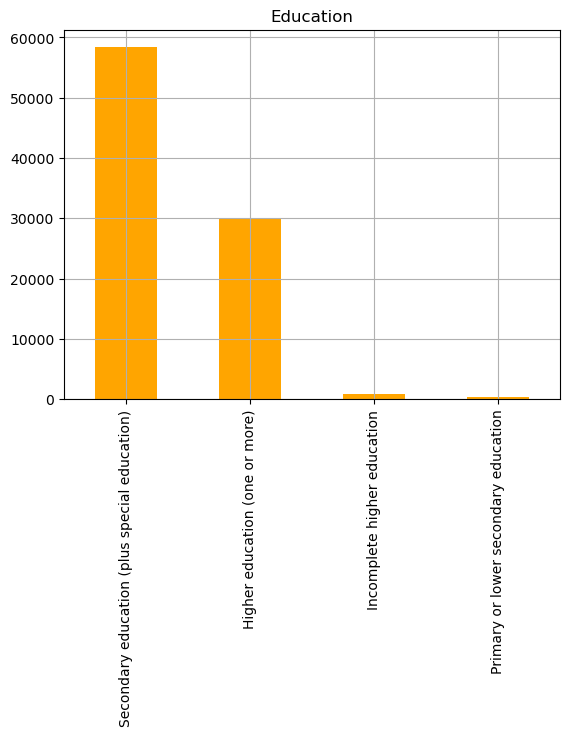

In [21]:
train['Education'].value_counts().plot(kind='bar', color='orange')
plt.grid()
plt.title('Education');

### <span style="color: green">Display value counts for 'Marriage'

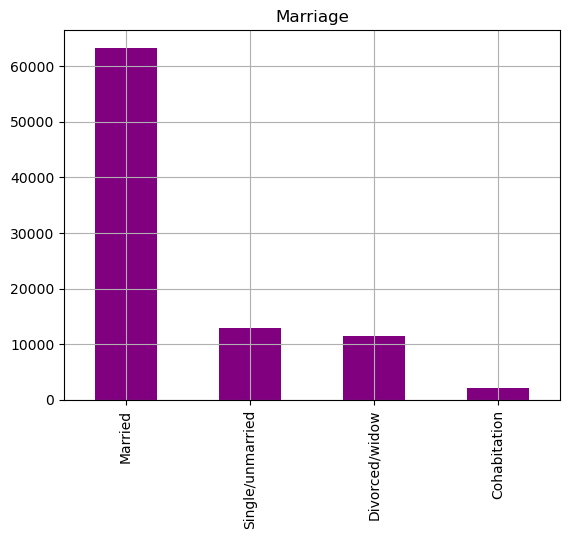

In [22]:
train['Marriage'].value_counts().plot(kind='bar', color='purple')
plt.grid()
plt.title('Marriage');

### <span style="color: green">Display value counts for 'Property'

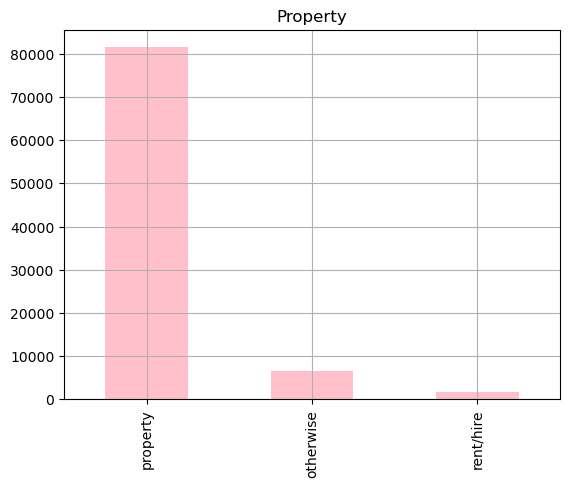

In [23]:
train['Property'].value_counts().plot(kind='bar', color='pink')
plt.grid()
plt.title('Property');

### <span style="color: green">Display value counts for 'Employment_status'

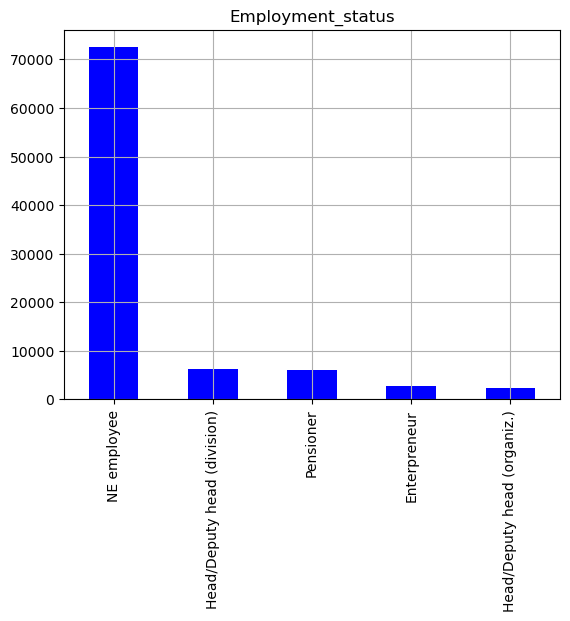

In [24]:
train['Job_title'].value_counts().plot(kind='bar', color='blue')
plt.grid()
plt.title('Employment_status');

<a id='10'></a>
# <span style="color: green">Let's analyse target of train data

In [25]:
print(train.MARKER.value_counts(), end='\n\n')  # see class imbalance (99.6% of class '0')
print(train.MARKER.value_counts() / train.shape[0])

0    89392
1      342
Name: MARKER, dtype: int64

0    0.996189
1    0.003811
Name: MARKER, dtype: float64


<a id='11'></a>
# <span style="color: green">Let's analyse target of test data

In [26]:
print(test.MARKER.value_counts(), end='\n\n')  # see class imbalance (99.6% of class '0')
print(test.MARKER.value_counts() / test.shape[0])

0    38259
1      146
Name: MARKER, dtype: int64

0    0.996198
1    0.003802
Name: MARKER, dtype: float64


#### <span style="color: orange">Let's solve problem above little later</span>

In [27]:
# We can check mean values of all features for customers who won't give loan back
train[train.MARKER == 1].mean()

/tmp/ipykernel_20/2694501565.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train[train.MARKER == 1].mean()


ID        30066.014620
A             0.166924
B             0.134099
C            93.941140
D           796.529386
E             1.442544
F             1.163732
G            11.719298
H             1.604781
J            36.975877
L            52.347953
MARKER        1.000000
dtype: float64

<a id='12'></a>
# <span style="color: green">Let's see how many NaN values are in data

In [28]:
print('Train data', ' ', train.isna().sum(), sep='\n', end='\n\n')
print('-' * 50, end='\n\n')
print('Test data', ' ', test.isna().sum(), sep='\n', end='\n\n')

Train data
 
ID                   0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
H                    0
Sex                  0
J                    0
Region               0
L                    0
Job_title            0
Education            0
Marriage             0
Children             0
Property             0
R                    0
Employment_status    0
T                    0
U                    0
V                    0
W                    0
X                    0
MARKER               0
dtype: int64

--------------------------------------------------

Test data
 
ID                   0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
H                    0
Sex                  0
J                    0
Region               0
L                    0
Job_title   

#### <span style="color: orange">As we see there are no empty values in the data</span>

<a id='13'></a>
# <span style="color: green">Look at the data type of the training set

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89734 entries, 0 to 89733
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 89734 non-null  int64  
 1   A                  89734 non-null  float64
 2   B                  89734 non-null  float64
 3   C                  89734 non-null  float64
 4   D                  89734 non-null  float64
 5   E                  89734 non-null  float64
 6   F                  89734 non-null  float64
 7   G                  89734 non-null  int64  
 8   H                  89734 non-null  float64
 9   Sex                89734 non-null  object 
 10  J                  89734 non-null  float64
 11  Region             89734 non-null  object 
 12  L                  89734 non-null  int64  
 13  Job_title          89734 non-null  object 
 14  Education          89734 non-null  object 
 15  Marriage           89734 non-null  object 
 16  Children           897

<a id='14'></a>
# <span style="color: green">Split the training dataset into X and y

In [30]:
X = train.drop(['ID', 'MARKER'], axis=1)
y = train.MARKER

<a id='15'></a>
# <span style="color: green">Split test data into answer (target of test)

In [31]:
answer = test.MARKER
test_ID = test.ID
test = test.drop(['ID', 'MARKER'], axis=1)

<a id='16'></a>
# <span style="color: green">Let's do a One-Hot transformation

In [32]:
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

<a id='17'></a>
# <span style="color: green">Display a complete list of new features

In [33]:
X.columns.tolist()

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'L',
 'Sex_Woman',
 'Region_Gomel region',
 'Region_Grodno region',
 'Region_Minsk',
 'Region_Minsk region',
 'Region_Mogilev region',
 'Region_Vitebsk region',
 'Job_title_Head/Deputy head (division)',
 'Job_title_Head/Deputy head (organiz.)',
 'Job_title_NE employee',
 'Job_title_Pensioner',
 'Education_Incomplete higher education',
 'Education_Primary or lower secondary education',
 'Education_Secondary education (plus special education)',
 'Marriage_Divorced/widow',
 'Marriage_Married',
 'Marriage_Single/unmarried',
 'Children_1 One',
 'Children_2 Two',
 'Children_3 Three',
 'Children_More than 3',
 'Property_property',
 'Property_rent/hire',
 'R_Yes',
 'Employment_status_Pensioner',
 'Employment_status_Student',
 'Employment_status_Unemployed',
 'Employment_status_Works',
 'T_Yes',
 'U_Yes',
 'V_No',
 'V_Yes',
 'W_Yes',
 'X_Yes']

<a id='18'></a>
# <span style="color: green">Build a heat map of correlations (sns.heatmap produced anomalous errors)

In [34]:
correlation = X.corr()
correlation.style.background_gradient(cmap='PuBu')

,A,B,C,D,E,F,G,H,J,L,Sex_Woman,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_property,Property_rent/hire,R_Yes,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_Yes,U_Yes,V_No,V_Yes,W_Yes,X_Yes
A,1.000000,0.787760,0.279254,0.390606,0.648925,0.473056,-0.324324,-0.229381,0.154316,0.011154,0.149300,0.016255,0.015170,-0.037219,-0.011192,0.024513,-0.004739,-0.051073,-0.016919,-0.051990,0.179834,-0.006163,0.005013,0.069637,0.002221,0.006876,-0.019012,-0.069120,-0.071544,-0.027904,-0.012326,0.040525,-0.028780,-0.034517,0.090146,-0.005758,-0.093160,0.028238,0.037167,-0.009326,0.084198,-0.076897,-0.080715,0.092369
B,0.787760,1.000000,0.282321,0.371655,0.471430,0.657744,-0.317508,-0.212887,0.081070,-0.009512,0.053479,0.022444,0.009723,-0.023171,-0.017510,0.015359,-0.006042,-0.043233,-0.013232,-0.030038,0.123836,0.005617,0.004599,0.059332,0.200160,-0.280887,0.183912,-0.081647,-0.097244,-0.026426,-0.007639,0.006141,-0.013065,-0.053565,0.025072,0.005375,0.058494,-0.306655,0.031703,-0.004206,0.078257,-0.071820,-0.085488,0.081038
C,0.279254,0.282321,1.000000,0.495777,0.318026,0.322362,0.019881,-0.211125,-0.002666,0.011004,-0.048296,0.009919,-0.034060,0.058811,0.003578,0.023828,-0.023780,0.035767,0.048484,-0.053151,-0.020952,0.000166,-0.012127,-0.085327,-0.025228,0.009752,0.009789,-0.017796,-0.010412,-0.008427,-0.004082,0.016871,-0.009459,0.032653,-0.002500,-0.004144,0.006764,0.005782,-0.013914,-0.004304,0.034681,-0.031627,-0.045180,-0.082019
D,0.390606,0.371655,0.495777,1.000000,0.733874,0.702949,0.336855,-0.041913,0.030375,0.032271,-0.037662,0.004560,-0.046608,0.087795,0.014765,0.024001,-0.035309,0.042866,0.059462,-0.055380,-0.030965,-0.000877,-0.007476,-0.070801,-0.029684,0.037277,-0.028963,-0.018335,-0.012231,0.003689,-0.004126,0.035775,-0.021384,0.046840,-0.002467,-0.004682,0.001162,0.034613,-0.007673,-0.000221,0.017212,-0.017723,-0.023294,0.225930
E,0.648925,0.471430,0.318026,0.733874,1.000000,0.782391,0.279598,0.021942,0.113036,-0.006566,0.142138,0.012407,0.011609,-0.032243,-0.021496,0.040214,-0.001851,-0.047668,-0.007088,-0.040594,0.150497,-0.003167,0.008041,0.066227,-0.005840,0.015785,-0.026452,-0.055630,-0.058841,-0.017364,-0.014672,0.037401,-0.024176,-0.029782,0.059443,-0.006253,-0.084032,0.043976,0.024644,-0.006263,0.058683,-0.054196,-0.058909,0.187421
F,0.473056,0.657744,0.322362,0.702949,0.782391,1.000000,0.275341,0.044503,0.042328,-0.027840,0.042214,0.018135,0.006850,-0.019260,-0.027642,0.029893,-0.001798,-0.040214,-0.003594,-0.021675,0.099746,0.008931,0.007186,0.056981,0.192573,-0.272640,0.177479,-0.068677,-0.085851,-0.016672,-0.009440,0.005554,-0.009132,-0.049549,-0.000412,0.004925,0.075702,-0.299199,0.020192,-0.001466,0.051572,-0.047948,-0.064461,0.171696
G,-0.324324,-0.317508,0.019881,0.336855,0.279598,0.275341,1.000000,0.597774,-0.058046,-0.036009,-0.012810,-0.006097,-0.010101,0.004886,-0.013200,0.008231,0.019025,0.002652,0.006956,0.017980,-0.032574,0.008015,0.007184,0.019647,-0.002649,0.002047,-0.007451,0.025944,0.014158,0.016207,0.003105,-0.004767,0.008236,0.004718,-0.035248,-0.000060,0.010776,0.010397,-0.010697,-0.002203,-0.052516,0.046035,0.040366,0.106804
H,-0.229381,-0.212887,-0.211125,-0.041913,0.021942,0.044503,0.597774,1.000000,-0.062062,-0.046920,-0.003752,-0.001776,-0.008228,-0.044233,-0.017166,-0.022835,0.067950,-0.029315,-0.025651,0.058586,-0.020049,0.010949,0.018608,0.108377,0.027386,-0.038627,0.016588,0.031663,0.010871,0.017250,0.008316,-0.023999,0.023077,-0.013594,-0.028798,0.001449,-

<a id='19'></a>
# <span style="color: green">Remove properties 'A', 'D' and 'E' to avoid multicorrelation

In [35]:
X.drop(['A', 'D', 'E', 'F'], axis=1, inplace=True)
test.drop(['A', 'D', 'E', 'F'], axis=1, inplace=True)

<a id='20'></a>
# <span style="color: green">Check new correlation heatmap

In [36]:
correlation = X.corr()
correlation.style.background_gradient(cmap='YlOrRd')

,B,C,G,H,J,L,Sex_Woman,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_property,Property_rent/hire,R_Yes,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_Yes,U_Yes,V_No,V_Yes,W_Yes,X_Yes
B,1.000000,0.282321,-0.317508,-0.212887,0.081070,-0.009512,0.053479,0.022444,0.009723,-0.023171,-0.017510,0.015359,-0.006042,-0.043233,-0.013232,-0.030038,0.123836,0.005617,0.004599,0.059332,0.200160,-0.280887,0.183912,-0.081647,-0.097244,-0.026426,-0.007639,0.006141,-0.013065,-0.053565,0.025072,0.005375,0.058494,-0.306655,0.031703,-0.004206,0.078257,-0.071820,-0.085488,0.081038
C,0.282321,1.000000,0.019881,-0.211125,-0.002666,0.011004,-0.048296,0.009919,-0.034060,0.058811,0.003578,0.023828,-0.023780,0.035767,0.048484,-0.053151,-0.020952,0.000166,-0.012127,-0.085327,-0.025228,0.009752,0.009789,-0.017796,-0.010412,-0.008427,-0.004082,0.016871,-0.009459,0.032653,-0.002500,-0.004144,0.006764,0.005782,-0.013914,-0.004304,0.034681,-0.031627,-0.045180,-0.082019
G,-0.317508,0.019881,1.000000,0.597774,-0.058046,-0.036009,-0.012810,-0.006097,-0.010101,0.004886,-0.013200,0.008231,0.019025,0.002652,0.006956,0.017980,-0.032574,0.008015,0.007184,0.019647,-0.002649,0.002047,-0.007451,0.025944,0.014158,0.016207,0.003105,-0.004767,0.008236,0.004718,-0.035248,-0.000060,0.010776,0.010397,-0.010697,-0.002203,-0.052516,0.046035,0.040366,0.106804
H,-0.212887,-0.211125,0.597774,1.000000,-0.062062,-0.046920,-0.003752,-0.001776,-0.008228,-0.044233,-0.017166,-0.022835,0.067950,-0.029315,-0.025651,0.058586,-0.020049,0.010949,0.018608,0.108377,0.027386,-0.038627,0.016588,0.031663,0.010871,0.017250,0.008316,-0.023999,0.023077,-0.013594,-0.028798,0.001449,-0.001115,-0.021912,-0.002557,-0.013960,-0.075442,0.067150,0.055485,-0.105762
J,0.081070,-0.002666,-0.058046,-0.062062,1.000000,0.408005,0.209313,-0.003100,-0.009376,0.002193,0.002476,0.016102,0.015643,0.012275,0.024101,-0.283776,0.435952,-0.090324,0.015090,0.113595,0.210148,0.030647,-0.244679,-0.220086,-0.205190,-0.070231,-0.016185,0.196384,-0.089327,-0.048742,0.347371,-0.034462,-0.214973,0.018130,0.173331,-0.031355,0.031730,-0.033154,0.051991,0.043696
L,-0.009512,0.011004,-0.036009,-0.046920,0.408005,1.000000,0.104807,0.016843,0.018911,-0.048925,0.005651,0.010853,0.005834,0.058077,-0.003075,0.023461,-0.067864,-0.049506,-0.003636,0.039583,0.066486,0.052255,-0.129179,-0.072677,-0.069217,-0.028474,-0.010503,0.096936,-0.045886,-0.015714,0.081927,-0.017922,-0.096078,0.075928,0.104616,0.016369,-0.032134,0.029440,0.073748,0.017727
Sex_Woman,0.053479,-0.048296,-0.012810,-0.003752,0.209313,0.104807,1.000000,-0.009010,-0.008656,-0.015770,-0.006898,0.018527,0.025422,-0.025317,-0.040457,-0.027336,0.139304,-0.006715,-0.010795,-0.035581,0.208570,-0.159430,0.004697,-0.039071,-0.111873,-0.073068,-0.034264,0.047522,-0.025815,-0.158955,0.042189,-0.022591,-0.296222,0.032770,0.061482,-0.004689,0.013755,-0.014618,-0.011873,0.005638
Region_Gomel region,0.022444,0.009919,-0.006097,-0.001776,-0.003100,0.016843,-0.009010,1.000000,-0.162649,-0.173001,-0.182148,-0.133313,-0.162244,-0.011545,-0.007016,-0.001238,0.017657,-0.008853,0.006079,-0.019136,0.011186,-0.011015,-0.005567,0.007096,0.002199,-0.013991,-0.004912,0.072462,-0.007175,-0.070720,0.003987,0.000108,0.019296,-0.024632,-0.001163,0.090833,-0.080104,0.075990,-0.031797,-0.003011
Region_Grodno region,0.009723,-0.034060,-0.010101,-0.008228,-0.009376,0.018911,-0.008656,-0.162649,1.000000,-0.173973,-0.183171,-0.134062,-0.163156,-0.007045,-0.014339,0.014571,-0.003935,-0.00

<a id='21'></a>
# <span style="color: green">Split training-data into train and test and use SMOKE to crash inbalance of classes

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<a id='22'></a>
# <span style="color: green">Define base models with tuned hyperparameters

In [38]:
base_models = [
    ('catboost', CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=7,
        random_state=27
    )),
    ('xgboost', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        random_state=27
    )),
    ('lightgbm', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        random_state=27
    ))
]

<a id='23'></a>
# <span style="color: green">Defining the meta-model with tuned hyperparameters

In [39]:
meta_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=7,
    random_state=27
)

<a id='24'></a>
# <span style="color: green">Creating the stacking model

In [40]:
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

<a id='25'></a>
# <span style="color: green">Fitting the stacking model to the entire training data

In [41]:
stacking_model.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.5527616	total: 88.7ms	remaining: 8.78s
1:	learn: 0.4525573	total: 116ms	remaining: 5.68s
2:	learn: 0.3842756	total: 145ms	remaining: 4.7s
3:	learn: 0.3390420	total: 174ms	remaining: 4.18s
4:	learn: 0.3056960	total: 201ms	remaining: 3.83s
5:	learn: 0.2730160	total: 229ms	remaining: 3.6s
6:	learn: 0.2452725	total: 257ms	remaining: 3.41s
7:	learn: 0.2246838	total: 281ms	remaining: 3.24s
8:	learn: 0.2023572	total: 310ms	remaining: 3.14s
9:	learn: 0.1817072	total: 338ms	remaining: 3.04s
10:	learn: 0.1703237	total: 364ms	remaining: 2.95s
11:	learn: 0.1634328	total: 393ms	remaining: 2.88s
12:	learn: 0.1539028	total: 420ms	remaining: 2.81s
13:	learn: 0.1451354	total: 447ms	remaining: 2.74s
14:	learn: 0.1358563	total: 477ms	remaining: 2.7s
15:	learn: 0.1305991	total: 505ms	remaining: 2.65s
16:	learn: 0.1249832	total: 538ms	remaining: 2.63s
17:	learn: 0.1200823	total: 562ms	remaining: 2.56s
18:	learn: 0.1160878	total: 589ms	remaining: 2.51s
19:	learn: 0.1124626	total: 614ms	remaining

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7d0e02682f20>),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, gr...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=27, ...)),
                               ('lightgbm',
                                LGBMClassifier(max_depth=7, random_state=27))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7d0e026801c0>)

<a id='26'></a>
# <span style="color: green">Predict probabilities on the validation set

In [42]:
y_pred_proba_val = stacking_model.predict_proba(X_test)

<a id='27'></a>
# <span style="color: green">Predict probabilities on the test set

In [43]:
y_pred_proba_test = stacking_model.predict_proba(test)

<a id='28'></a>
# <span style="color: green">Calculate ROC AUC Score on the validation set

In [44]:
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val[:, 1])
print("Validation ROC AUC Score:", roc_auc_val)

Validation ROC AUC Score: 0.795716662623935


<a id='29'></a>
# <span style="color: green">Calculate ROC AUC Score on the test set

In [45]:
roc_auc_test = roc_auc_score(answer, y_pred_proba_test[:, 1])
print("Test ROC AUC Score:", roc_auc_test)

Test ROC AUC Score: 0.8589945887922512


<a id='30'></a>
# <span style="color: green">Find out how many defaults are expected in test data

In [46]:
result = stacking_model.predict(test)
print(f'{sum(result)} defaults')  # quantity of expecting defaults

90 defaults


<a id='31'></a>
# <span style="color: green">Build DataFrame to compare predictions with real results

In [47]:
results = pd.DataFrame()
results['ID'] = test_ID
results['My prediction'] = result
results['Real result'] = answer

wrong_predictions = len(results[results['My prediction'] != results['Real result']])
print(f'Wrong predictions {wrong_predictions}')

Wrong predictions 224


<a id='32'></a>
# <span style="color: green">Cheak how many data was predicted correctly

In [48]:
share_of_wrong_predicted = 1 - wrong_predictions / len(results.ID)
print(f'{share_of_wrong_predicted * 100:.2f}% were predicted right')

99.42% were predicted right
